
# Fairness & Repair Exploratory Analysis
### Kushagra Ghosh

In data cleaning, the objective is to ensure that data can adhere to the right quality and integrity constraints. Our data has constraints (functional dependencies or FDs) that we want the database to satisfy (such as Zip Code -> City, State). There are countless algorithms for data repair that take in data and delete tuples, change values, or add different tuples to satisfy FDs using ML and statistics about the data. However, by changing the data, these repair algorithms may hurt one population. For example, by deleting a higher proportion of female tuples, there may be a lower percentage of females in the final data, swaying our statistics and create bias. We would like to verify our assumption that data repair algorithms can introduce bias. 

The idea of this exploration exercise is to see how query answers differ after specific data transformations. Specifically, does the data become distorted due to these transformations and then may lead the analyst to the wrong conclusion due to bias? 

My first step was to retrive the dataset I am working with. Folktale is a package with various datasets, each with different tables and tasks to be predicted. I read the instructions and installed the package to work with the population dataset from here: https://github.com/zykls/folktables. This population dataset is from the American Community Survey Public Use Microdata Sample from https://www.census.gov/programs-surveys/acs/microdata/documentation.html.

In [62]:
%%capture
pip install folktables

In [66]:
from folktables import ACSDataSource, ACSIncome
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


I generated a uniform random sample from each state with approximately 50% or 40% percentage for sex, and representation for different protected subpopulations (such as different races).

In [67]:
%%capture
data_source = ACSDataSource(survey_year='2021', horizon='1-Year', survey='person')
original = data_source.get_data(density=0.01,download=True)

I also varied the density and random seed of my sampling from the US population dataset to see if I would also get a consistent distribution. From here on, I will be using the Sample 1 (original) since I do get a consistent distribution.

In [60]:
#Varying the density and the random seed
us_data2 = data_source.get_data(density=0.002,random_seed=12,download=False)

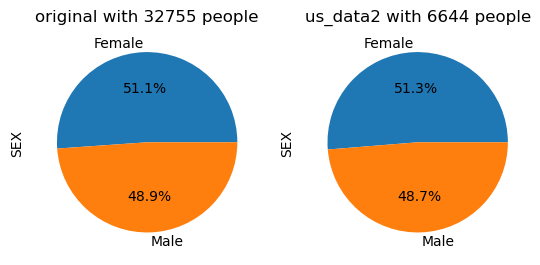

In [61]:
def piechart(title, df, ax, column, label_mapping):
    labels = df[column].value_counts().keys()
    df[column].value_counts().plot(kind="pie", autopct='%1.1f%%', ax=ax, labels =[label_mapping[l] for l in labels])
    ax.set_title(title)
    
fig, axs = plt.subplots(1, 2)
sex_label_mapping = {1: 'Male', 2: 'Female'}
piechart(f"original with {original.shape[0]} people", original, axs[0], 'SEX', sex_label_mapping)
piechart(f"us_data2 with {us_data2.shape[0]} people", us_data2, axs[1], 'SEX', sex_label_mapping)
plt.show()

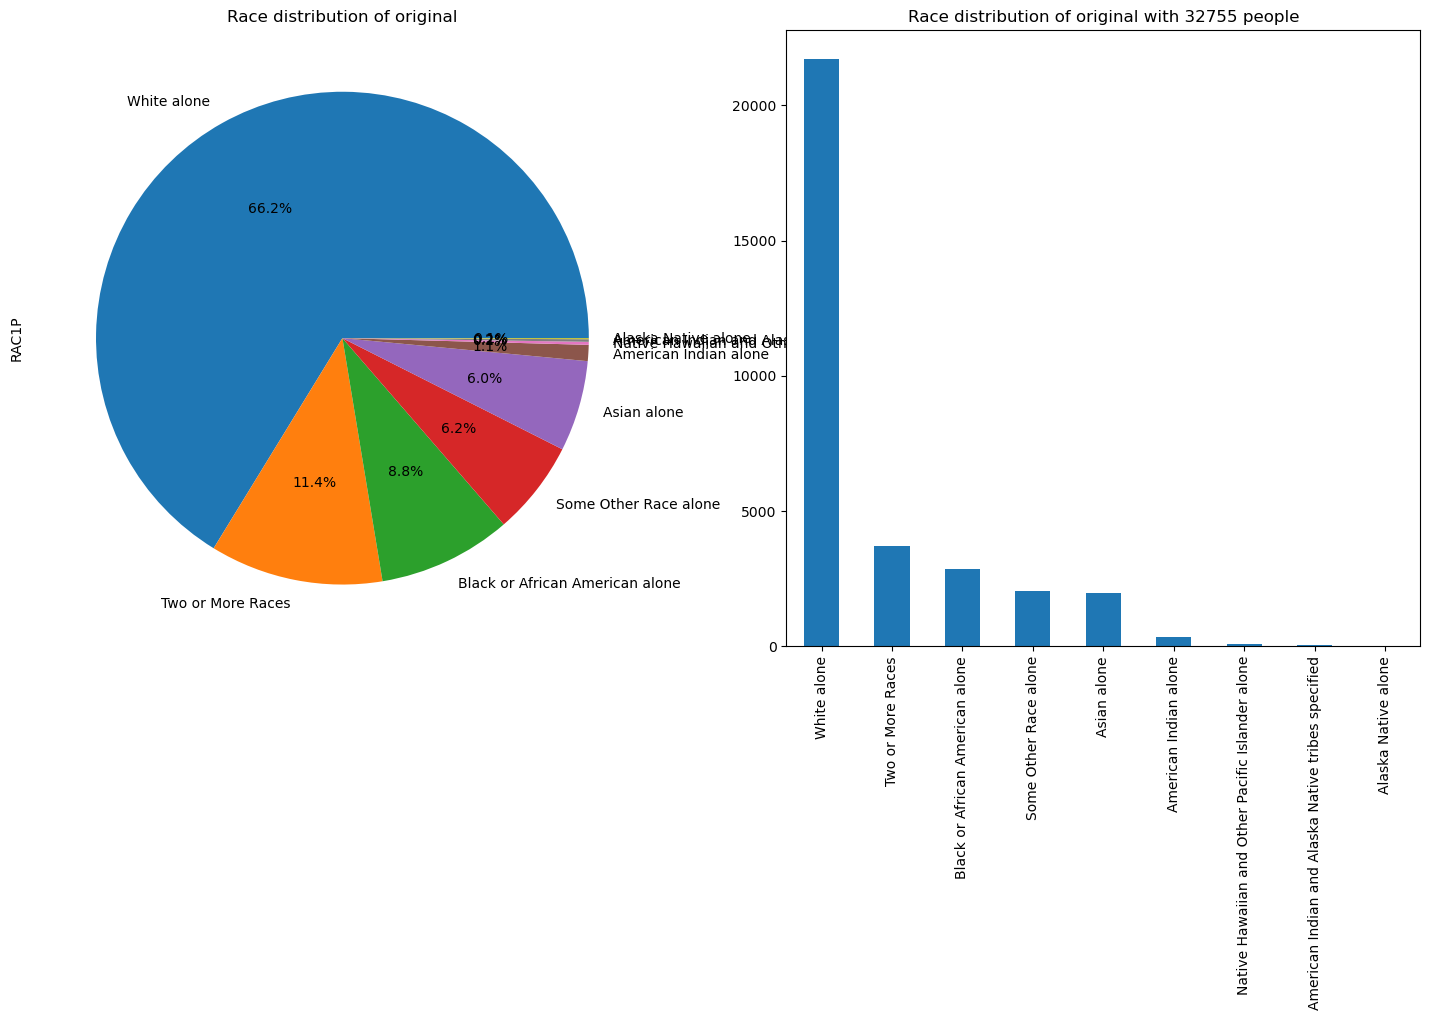

In [7]:
def barplotForCounts(title, df, ax, column, label_mapping):
    labels = df[column].value_counts().keys()
    df[column].value_counts().plot(kind="bar", ax=ax)
    ax.set_xticks(range(len(labels)), [label_mapping[l] for l in labels])
    #display(df[column].value_counts())
    ax.set_title(title)

fig, axs = plt.subplots(1,2, figsize=(18,8))
race_label_mapping = {1: 'White alone', 2: 'Black or African American alone', 3: 'American Indian alone', 4: 'Alaska Native alone', 5: 'American Indian and Alaska Native tribes specified', 6: 'Asian alone', 7: 'Native Hawaiian and Other Pacific Islander alone', 8: 'Some Other Race alone', 9: 'Two or More Races'}
piechart("Race distribution of original", original, axs[0], 'RAC1P', race_label_mapping)
barplotForCounts(f"Race distribution of original with {original.shape[0]} people", original, axs[1], 'RAC1P', race_label_mapping)
plt.show()

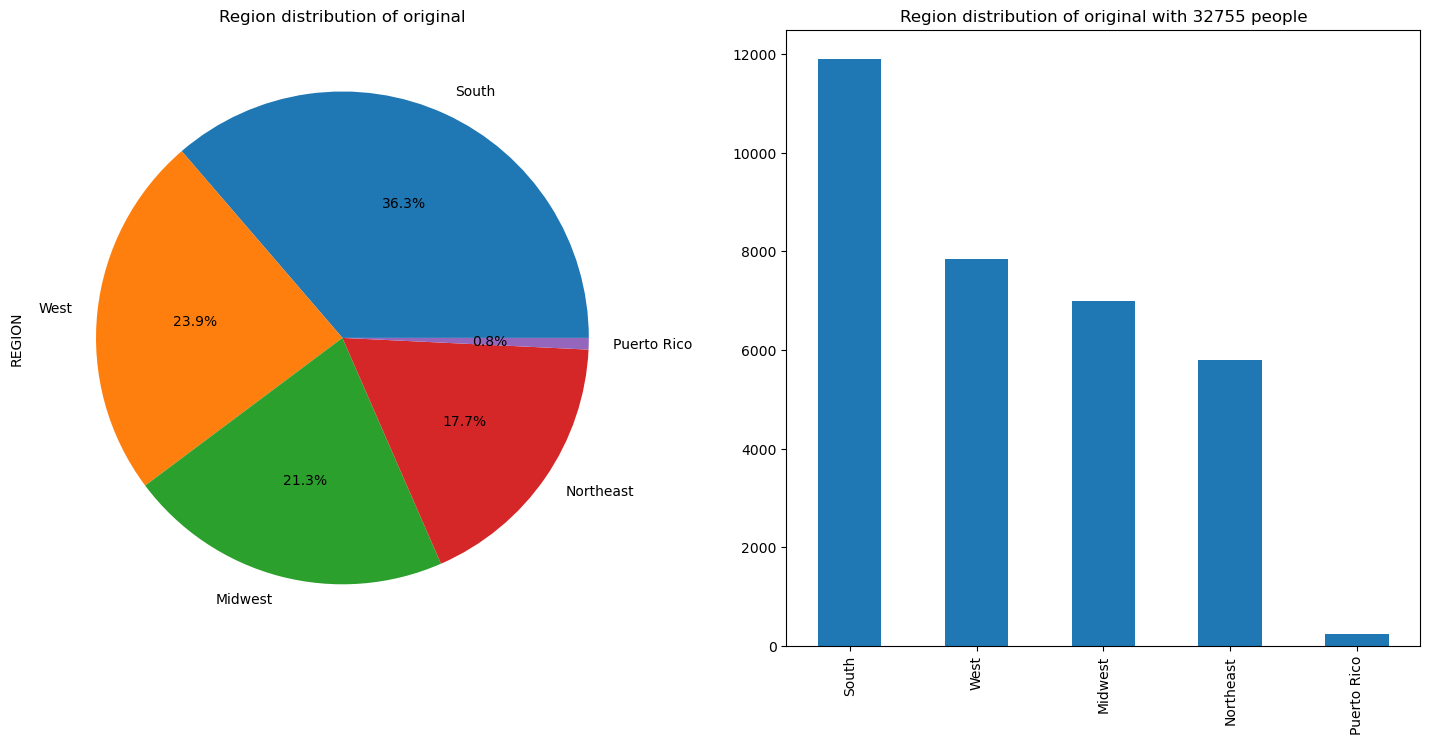

In [8]:
fig, axs = plt.subplots(1,2, figsize=(18,8))
region_label_mapping = {1: 'Northeast', 2: 'Midwest', 3: 'South', 4: 'West', 9: 'Puerto Rico'}
piechart("Region distribution of original", original, axs[0], 'REGION', region_label_mapping)
barplotForCounts(f"Region distribution of original with {original.shape[0]} people", original, axs[1], 'REGION', region_label_mapping)
plt.show()

I computed the average income for the entire population and for different protected subpopulations (different sexes, different races). I also computed the proportion of people making > 50k a year for the entire population. 

In [9]:
def average_income(df, column=None, value=None):
    df = df[df[column]==value] if column is not None else df
    return np.mean(df['PINCP'])

def proportion_above_50k(df, column=None, value=None):
    df = df[df[column]==value] if column is not None else df
    return df.loc[df['PINCP'] > 50000].shape[0]/df.shape[0]

print(f"Average income in original: ${average_income(original):.2f}")
print(f"Proportion of people making > 50K a year in original: {proportion_above_50k(original):.3%}")

Average income in original: $45093.63
Proportion of people making > 50K a year in original: 23.938%


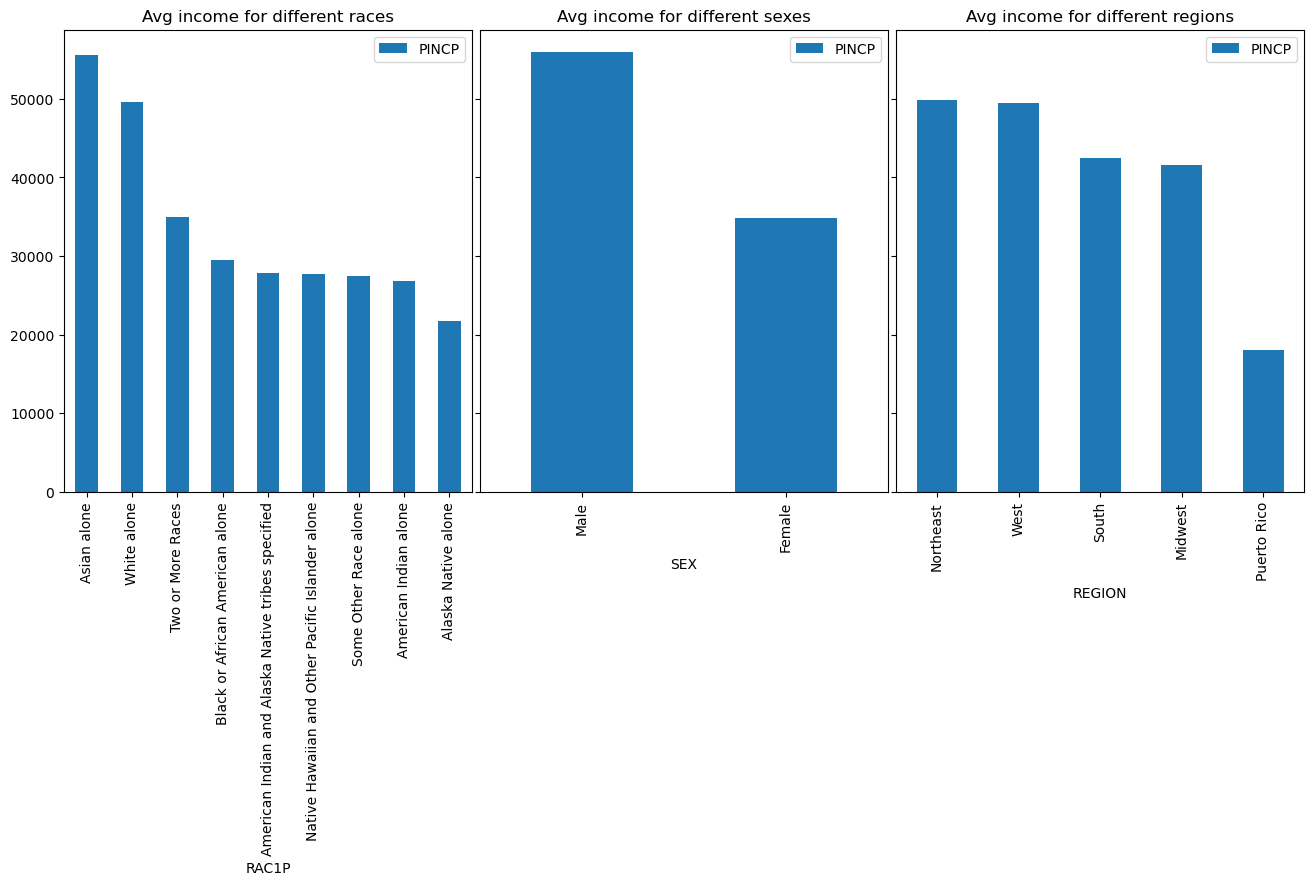

In [10]:
def barplotForAvg(title, df, column, ax, label_mapping):
    averages = df.pivot_table(values='PINCP', index=column, aggfunc='mean').sort_values(ascending=False, by='PINCP')
    labels = list(averages.index.values)
    averages.plot.bar(ax=ax)
    ax.set_xticks(range(len(labels)), [label_mapping[l] for l in labels])
    #ax.axhline(avg_income, color='red', linewidth=2)
    ax.set_title(title)
    
fig, axs = plt.subplots(1, 3, figsize=(16,6), sharey=True)
barplotForAvg("Avg income for different races", original, 'RAC1P', axs[0], race_label_mapping)
barplotForAvg("Avg income for different sexes", original, 'SEX', axs[1], sex_label_mapping)
barplotForAvg("Avg income for different regions", original, 'REGION', axs[2], region_label_mapping)

fig.subplots_adjust(wspace=0.02)
plt.show()

Then, I found a functional dependency (FD) that is satisfied by the data using https://github.com/USEPA/FDTool. I needed to make a python 2.7 environment with conda to run FDTool.

In [11]:
original = original[['RAC1P', 'SEX', 'REGION', 'PINCP', 'ST', 'COW', 'CIT', 'NATIVITY', 'MSP', 'SCHL', 'DIS','MIL']]
original.to_csv('original_census.csv',index=False)


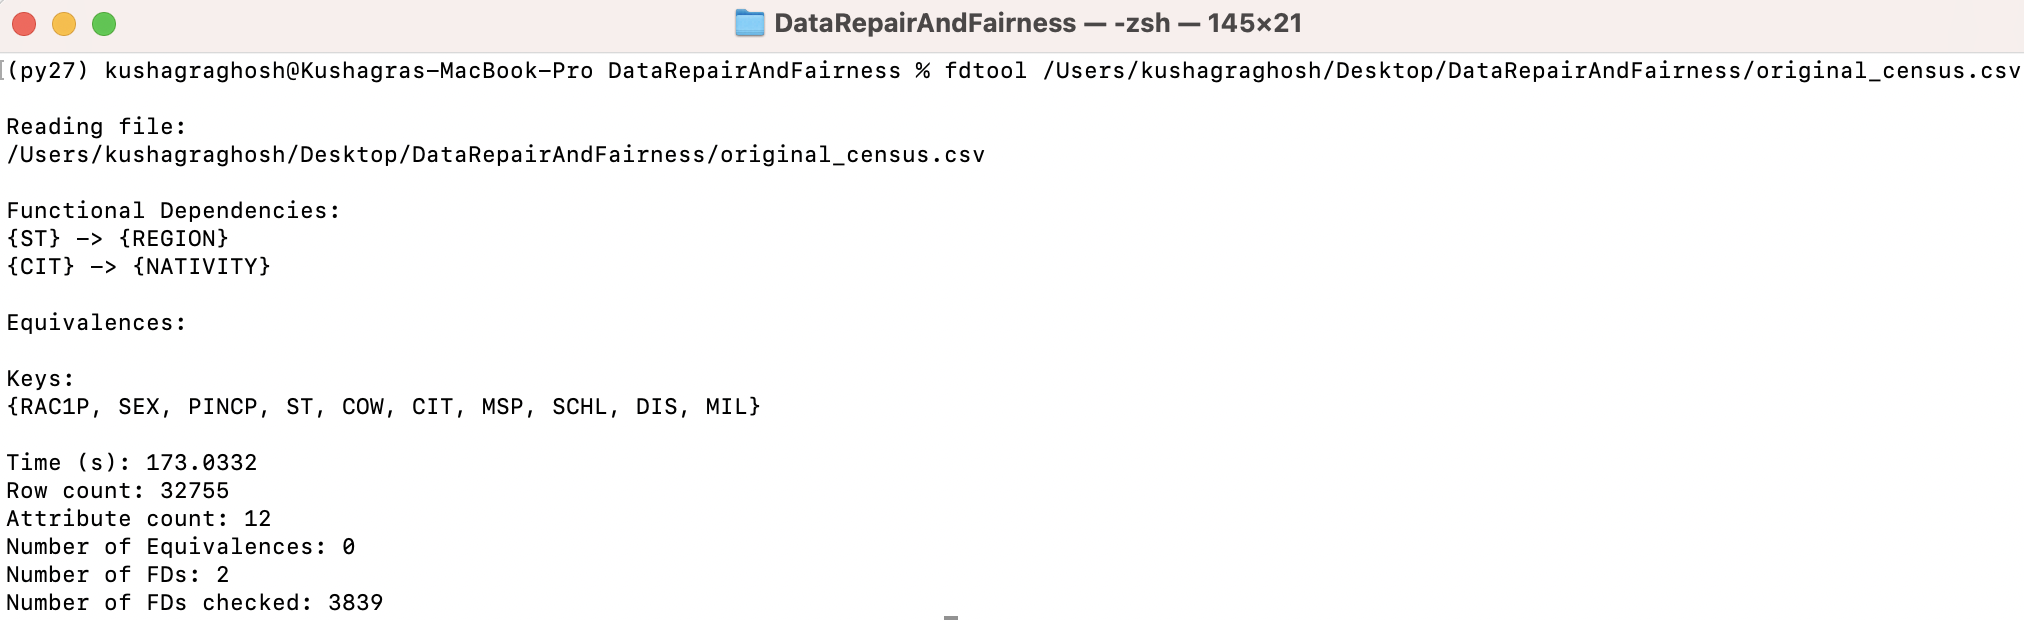

I verified that the FD or DC makes sense and that the data doesn't violate the FD or DC before moving to the next step. 

In [12]:
def satisfiesFD(df, col1, col2):
    return df.groupby([col1])[col2].nunique().eq(1).all()
def satisfiesDC(df, col1, val1, col2, val2):
    return df[df[col1] == val1][col2].eq(val2).sum() == 0

print(satisfiesFD(original,'ST','REGION'))
print(satisfiesFD(original,'CIT','NATIVITY'))

True
True


Then, I will generated synthetic data (with a machine learning model), which changes the values of the tuple but maintains the same number of tuples. With my new synthetic adult data, I will check how many violations of the Functional Dependencies and Denial Constraints I find, and how the various marginal distributions for income based on race, gender, education, and more is affected.

In [13]:
%%capture
pip install sdv

For the first synthetic data being generated from the original data (original), I decided to only use metadata about the numerical or categorical type of each attribute, and chose to specifically omit constraints such as the FixedConstraints (which is as close to Functional Dependencies or Denial Constraints as the SDV package offers). I will add these constraints in my second synthetic data generator that use the original data (original) and several constraints (FD or DC) that I observed in the data from above.

In [14]:
from sdv.metadata import SingleTableMetadata

def update_column(metadata, column_type, *args):
    for col in args:
        metadata.update_column(
            column_name=col,
            sdtype='categorical'
        )
        
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data=original)
update_column(metadata, 'categorical', 'RAC1P', 'SEX', 'REGION', 'ST', 'COW', 'CIT', 'NATIVITY', 'MSP', 'SCHL', 'DIS', 'MIL')

I experimented with using several synthetic data generators (from the Synthetic Data Vault package found at https://docs.sdv.dev/sdv/single-table-data/modeling/synthesizers) using various Copulas and Deep Learning based models. Finally, I used the FAST ML Preset synthesizer from https://docs.sdv.dev/sdv/single-table-data/modeling/synthesizers/fast-ml-preset to generate new synthetic data from the original data (adult_data) due to its quicker runtime and more accurate distributions compared to the original dataset. 

Generating synthetic data (version 1) without constraints, which will eventually be cleaned with Holoclean and Muse

In [15]:
from sdv.lite import SingleTablePreset

synthesizer = SingleTablePreset(metadata, name='FAST_ML')
synthesizer.fit(original)
synthetic_data = synthesizer.sample(num_rows=original.shape[0])
display(synthetic_data)

,RAC1P,SEX,REGION,PINCP,ST,COW,CIT,NATIVITY,MSP,SCHL,DIS,MIL
0,9,2,4,NaN,12,1.0,4,1,1.0,19.0,2,4.0
1,1,1,4,126359.506075,18,1.0,1,1,1.0,19.0,2,4.0
2,1,1,4,75127.858956,47,8.0,4,1,1.0,16.0,2,4.0
3,1,2,3,NaN,9,NaN,1,1,1.0,19.0,2,4.0
4,9,1,4,10790.547541,34,NaN,1,1,1.0,22.0,2,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
32750,1,2,2,NaN,41,1.0,1,1,6.0,4.0,2,4.0
32751,1,1,4,NaN,39,1.0,1,1,6.0,13.0,2,4.0
32752,1,2,2,93398.380846,15,6.0,1,1,6.0,21.0,2,4.0
32753,1,1,2,-1007.571261,8,NaN,1,1,NaN,1.0,2,NaN


I will test my claim about how synthetic data generators that don't consider integrity constraints doesn't preserve the full statistics and distributions of the original data because they don't fairly represent different protected subpopulations that appear less frequently in the original dataset. I will test this by creating another synthetic data generator with the same metadata but now with a combination of functional dependencies that was not present in the first synthetic data generator (which was called 'synthesizer'). 

I used FixedCombinations (https://docs.sdv.dev/sdv/reference/constraint-logic/predefined-constraint-classes) as a proxy for functional dependencies since FixedCombinations were one of the only constraints that the Synthetic Data Vault (SDV) generators take in that is closest to a FD (since they didn't have a way to explicitly define FDs).

In [16]:
fd = [['ST','REGION'], ['CIT','NATIVITY']]

def FixedCombinationsConstraint(fds):
    constraints = []
    for fd in fds:
        constraint = {
            'constraint_class': 'FixedCombinations',
            'constraint_parameters': {
                'column_names': fd
            }
        }
        constraints.append(constraint)
    return constraints

Generating synthetic data (version 2) with constraints

In [17]:
synthesizer2 = SingleTablePreset(metadata, name='FAST_ML')
synthesizer2.add_constraints(
    constraints=FixedCombinationsConstraint(fd)
)
synthesizer2.fit(original)
synthetic_data2 = synthesizer2.sample(num_rows=original.shape[0])
display(synthetic_data2)

Sampling rows: 100%|███████████████████| 32755/32755 [00:00<00:00, 52966.98it/s]


,RAC1P,SEX,REGION,PINCP,ST,COW,CIT,NATIVITY,MSP,SCHL,DIS,MIL
0,2,1,1,NaN,34,NaN,1,1,6.0,18.0,2,4.0
1,8,2,4,38393.426584,6,1.0,1,1,NaN,18.0,2,4.0
2,1,2,4,-8500.000000,56,1.0,1,1,1.0,21.0,2,4.0
3,1,1,3,NaN,47,3.0,1,1,1.0,22.0,2,4.0
4,1,1,2,92553.536861,29,1.0,1,1,NaN,21.0,2,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
32750,8,2,4,NaN,6,NaN,1,1,4.0,4.0,2,4.0
32751,1,2,4,NaN,8,NaN,1,1,1.0,18.0,2,4.0
32752,8,2,3,41345.910832,47,1.0,1,1,6.0,20.0,2,4.0
32753,1,2,1,15994.691291,25,3.0,1,1,1.0,22.0,2,4.0


In [18]:
synthetic_data.to_csv('synthetic_data_version_1.csv',index=False)

In [46]:
%%capture
pip install psycopg2

In [47]:
import psycopg2

# Establish a connection to the PostgreSQL database
conn = psycopg2.connect(
    database="holo",
    user="holocleanuser",
    password="abcd1234"
)

# Execute an SQL query and create a dataframe hospital_repaired
holoclean_data = pd.read_sql("SELECT * FROM synthetic_data_version_1_repaired", conn).iloc[:, 1:]

conn.close()

#Alternatively, access the new hospital data from the terminal in holoclean with:  1.   --user postgres     2. \c holo    3. \dt
#4. \copy (SELECT * FROM hospital_repaired) to '/Users/kushagraghosh/Desktop/DataRepairAndFairness/hospital_repaired.csv' with csv header;


/Users/kushagraghosh/opt/anaconda3/lib/python3.8/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [48]:
display(holoclean_data)

,RAC1P,SEX,REGION,PINCP,ST,COW,CIT,NATIVITY,MSP,SCHL,DIS,MIL
0,9,2,4,_nan_,12,1.0,4,1,1.0,19.0,2,4.0
1,1,1,4,126359.50607515374,18,1.0,1,1,1.0,19.0,2,4.0
2,1,1,4,75127.85895569899,47,8.0,4,1,1.0,16.0,2,4.0
3,1,2,3,_nan_,9,_nan_,1,1,1.0,19.0,2,4.0
4,9,1,4,10790.54754111301,34,_nan_,1,1,1.0,22.0,2,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
32750,1,2,2,_nan_,41,1.0,1,1,6.0,4.0,2,4.0
32751,1,1,4,_nan_,39,1.0,1,1,6.0,13.0,2,4.0
32752,1,2,2,93398.38084596951,15,6.0,1,1,6.0,21.0,2,4.0
32753,1,1,2,-1007.571260918121,8,_nan_,1,1,_nan_,1.0,2,4.0


In [49]:
print(holoclean_data.isna().sum().sum())
print(holoclean_data.eq('_nan_').sum().sum())
holoclean_data = holoclean_data.replace('_nan_', np.nan)

def make_col_int(df, *args):
    for col in args:
        df[col] = df[col].astype(float)
        df[col] = df[col].astype(int)
def make_col_float(df, *args):
    for col in args:
        df[col] = df[col].astype(float)
        
make_col_int(holoclean_data, 'RAC1P', 'SEX', 'REGION', 'ST', 'CIT', 'NATIVITY', 'DIS')
make_col_float(holoclean_data, 'PINCP', 'COW', 'MSP', 'SCHL', 'MIL')

0
19648


In [50]:
display(holoclean_data)

,RAC1P,SEX,REGION,PINCP,ST,COW,CIT,NATIVITY,MSP,SCHL,DIS,MIL
0,9,2,4,NaN,12,1.0,4,1,1.0,19.0,2,4.0
1,1,1,4,126359.506075,18,1.0,1,1,1.0,19.0,2,4.0
2,1,1,4,75127.858956,47,8.0,4,1,1.0,16.0,2,4.0
3,1,2,3,NaN,9,NaN,1,1,1.0,19.0,2,4.0
4,9,1,4,10790.547541,34,NaN,1,1,1.0,22.0,2,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
32750,1,2,2,NaN,41,1.0,1,1,6.0,4.0,2,4.0
32751,1,1,4,NaN,39,1.0,1,1,6.0,13.0,2,4.0
32752,1,2,2,93398.380846,15,6.0,1,1,6.0,21.0,2,4.0
32753,1,1,2,-1007.571261,8,NaN,1,1,NaN,1.0,2,4.0


To check how many tuples were changed using the HoloClean repair process on the synthetic data without constraints:

In [24]:
comparing = synthetic_data.compare(holoclean_data)
display(comparing)
print(f"{round(comparing.isna().eq(False).sum().sum()/2)} cells were changed")
print(f"{comparing.shape[0]} tuples (rows) out of a total {synthetic_data.shape[0]} were changed")

COW        MSP       SCHL        MIL      
      self other self other self other self other
13     NaN   NaN  NaN   NaN  NaN   NaN  NaN   4.0
16     NaN   1.0  NaN   NaN  NaN   NaN  NaN   NaN
27     NaN   1.0  NaN   6.0  NaN   NaN  NaN   NaN
28     NaN   1.0  NaN   NaN  NaN   NaN  NaN   4.0
30     NaN   1.0  NaN   6.0  NaN   NaN  NaN   NaN
...    ...   ...  ...   ...  ...   ...  ...   ...
32735  NaN   NaN  NaN   NaN  NaN   NaN  NaN   4.0
32741  NaN   1.0  NaN   NaN  NaN   NaN  NaN   NaN
32744  NaN   1.0  NaN   NaN  NaN   NaN  NaN   NaN
32749  NaN   NaN  NaN   NaN  NaN   NaN  NaN   4.0
32753  NaN   NaN  NaN   NaN  NaN   NaN  NaN   4.0

[6421 rows x 8 columns]

3734 cells were changed
6421 tuples (rows) out of a total 32755 were changed


Then, I generated the following __pie charts__: race-original, race-synthetic-without-constraints, race-synthetic-with-constraints, race-holoclean, race-muse, sex-original, sex-synthetic-without-constraints, sex-synthetic-with-constraints, sex-holoclean, and sex-muse.


I also generated the following __bar graphs__: income-race-original, income-race-synthetic-without-constraints, income-race-synthetic-with-constraints, income-race-holoclean, income-race-muse, income-sex-original, income-sex-synthetic-without-constraints, income-sex-synthetic-with-constraints, income-sex-holoclean, income-sex-muse

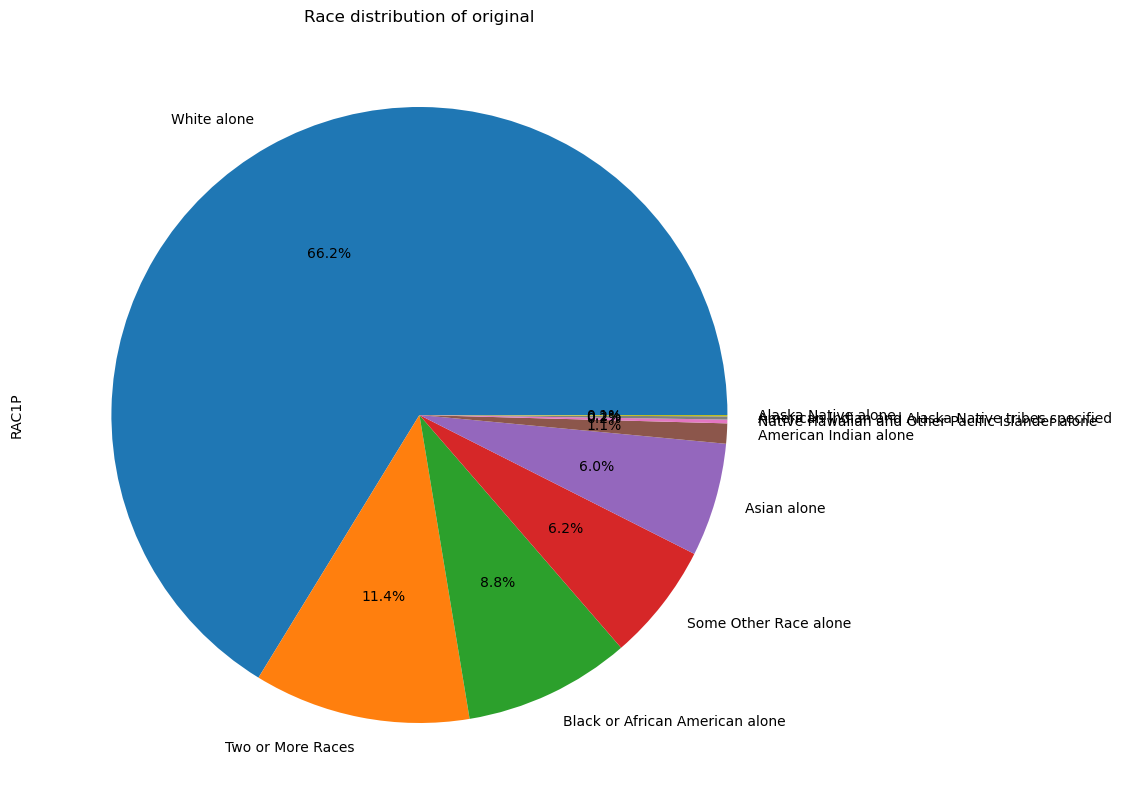

In [25]:
fig, axs = plt.subplots(1,1, figsize=(18,10))
piechart("Race distribution of original", original, axs, 'RAC1P', race_label_mapping)
plt.show()
fig.savefig('race-original.png', bbox_inches='tight')

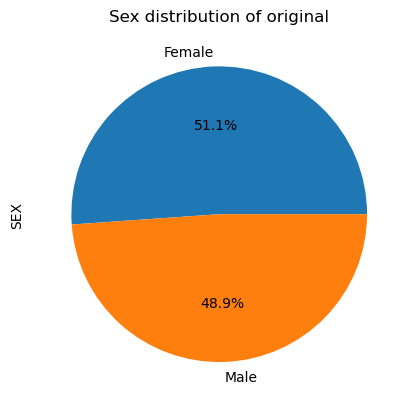

In [26]:
fig, axs = plt.subplots(1,1)
piechart("Sex distribution of original", original, axs, 'SEX', sex_label_mapping)
plt.show()
fig.savefig('sex-original.png', bbox_inches='tight')

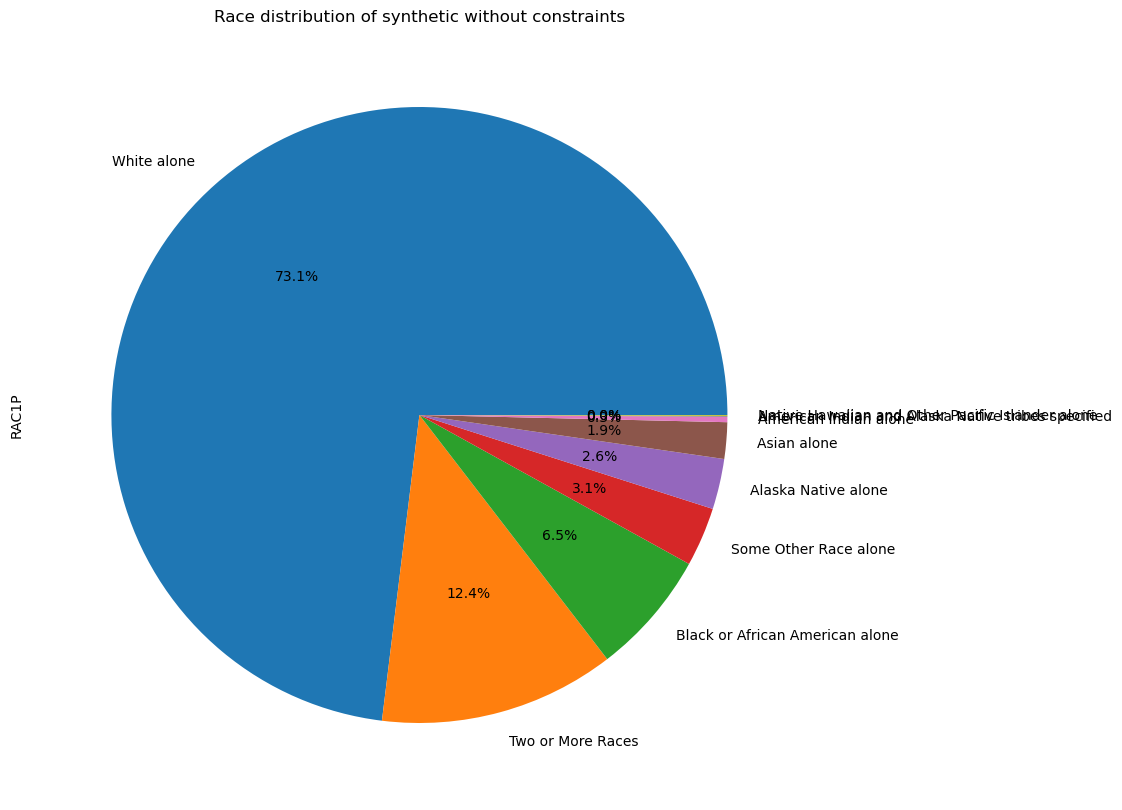

In [27]:
fig, axs = plt.subplots(1,1, figsize=(18,10))
piechart("Race distribution of synthetic without constraints", synthetic_data, axs, 'RAC1P', race_label_mapping)
plt.show()
fig.savefig('race-synthetic-without-constraints.png', bbox_inches='tight')

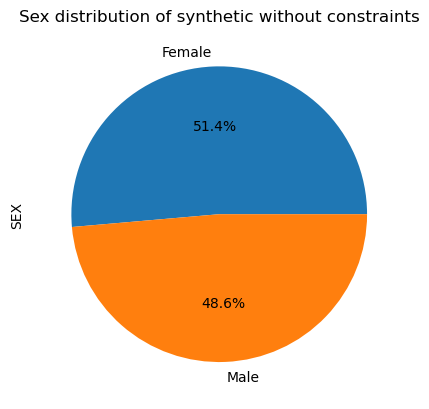

In [28]:
fig, axs = plt.subplots(1,1)
piechart("Sex distribution of synthetic without constraints", synthetic_data, axs, 'SEX', sex_label_mapping)
plt.show()
fig.savefig('sex-synthetic-without-constraints.png', bbox_inches='tight')

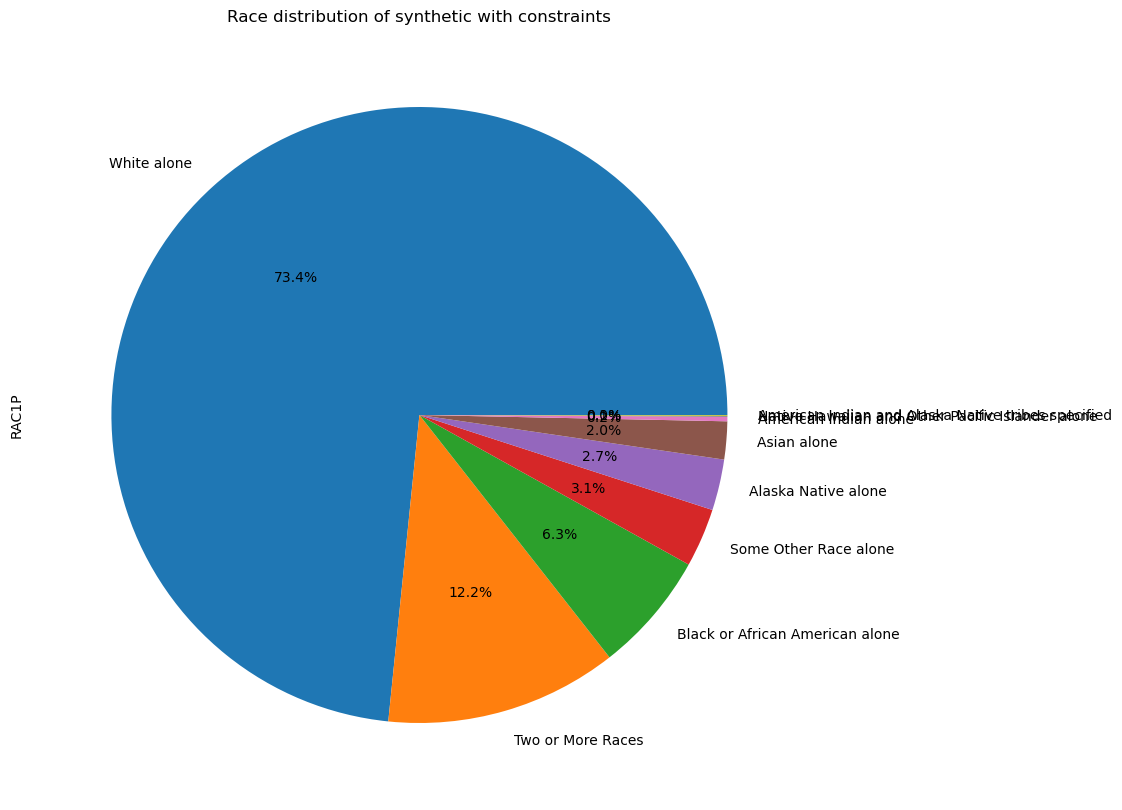

In [29]:
fig, axs = plt.subplots(1,1, figsize=(18,10))
piechart("Race distribution of synthetic with constraints", synthetic_data2, axs, 'RAC1P', race_label_mapping)
plt.show()
fig.savefig('race-synthetic-with-constraints.png', bbox_inches='tight')

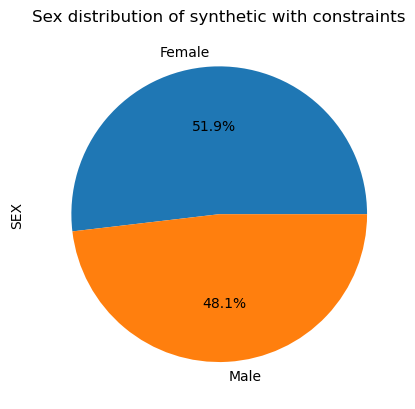

In [30]:
fig, axs = plt.subplots(1,1)
piechart("Sex distribution of synthetic with constraints", synthetic_data2, axs, 'SEX', sex_label_mapping)
plt.show()
fig.savefig('sex-synthetic-with-constraints.png', bbox_inches='tight')

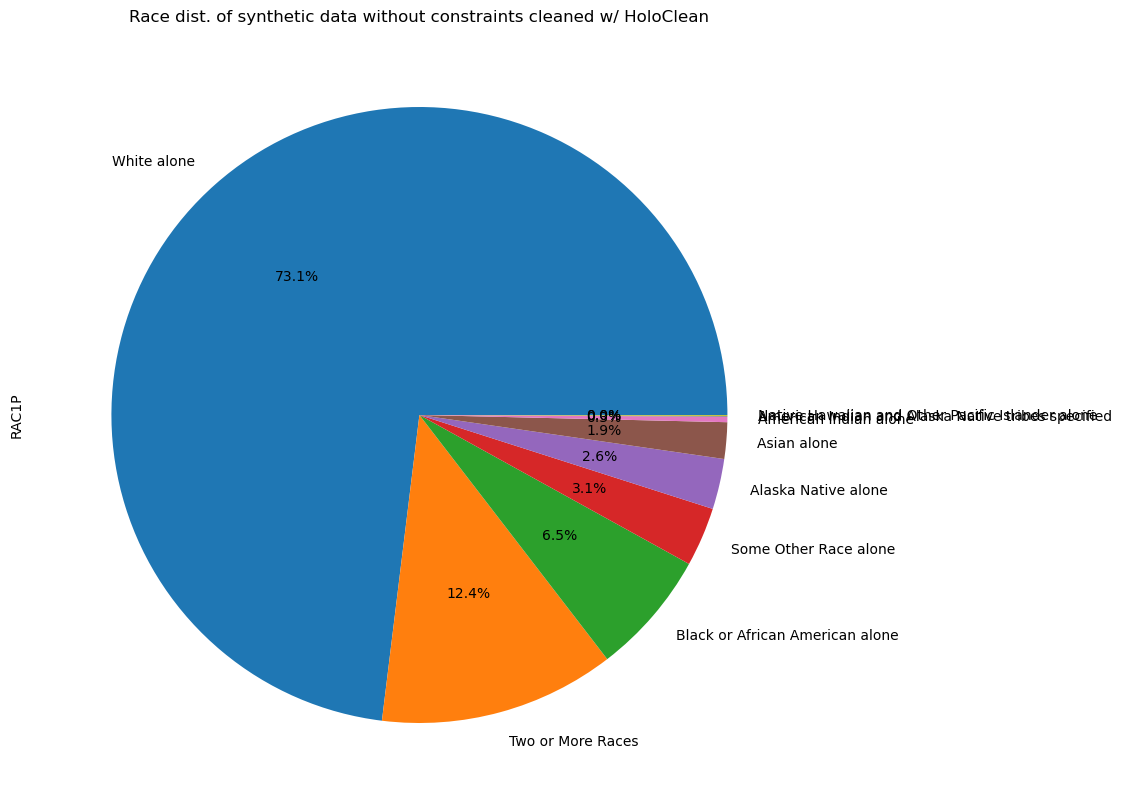

In [31]:
fig, axs = plt.subplots(1,1, figsize=(18,10))
piechart("Race dist. of synthetic data without constraints cleaned w/ HoloClean", holoclean_data, axs, 'RAC1P', race_label_mapping)
plt.show()
fig.savefig('race-holoclean.png', bbox_inches='tight')

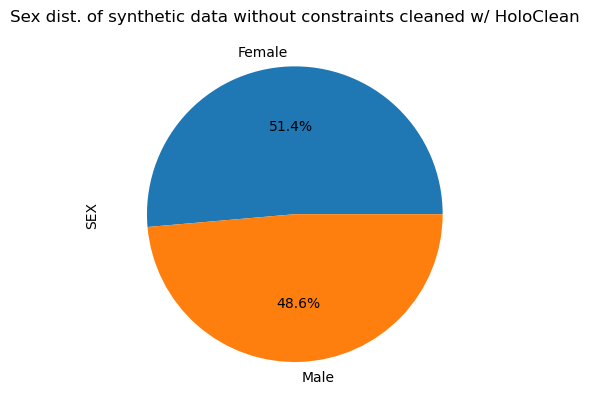

In [32]:
fig, axs = plt.subplots(1,1)
piechart("Sex dist. of synthetic data without constraints cleaned w/ HoloClean", holoclean_data, axs, 'SEX', sex_label_mapping)
plt.show()
fig.savefig('sex-holoclean.png', bbox_inches='tight')

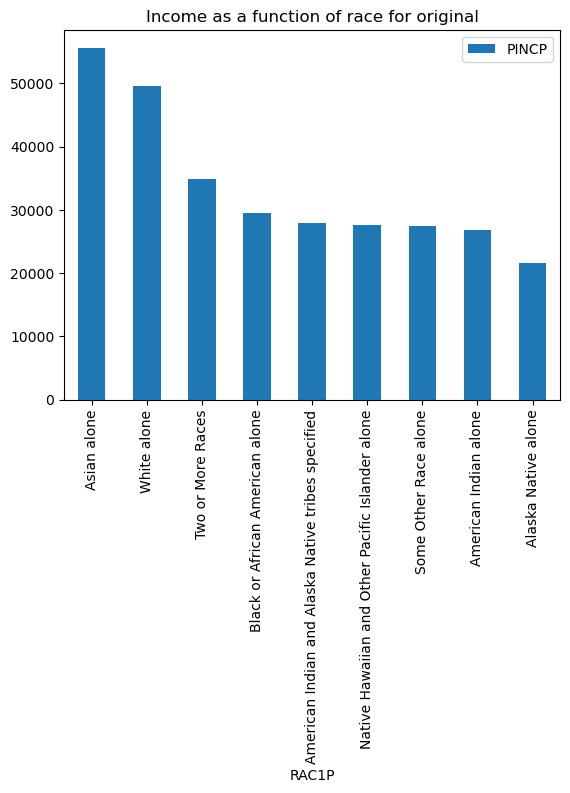

In [33]:
fig, axs = plt.subplots(1,1)
barplotForAvg("Income as a function of race for original", original, 'RAC1P', axs, race_label_mapping)
plt.show()
fig.savefig('income-race-original.png', bbox_inches='tight')

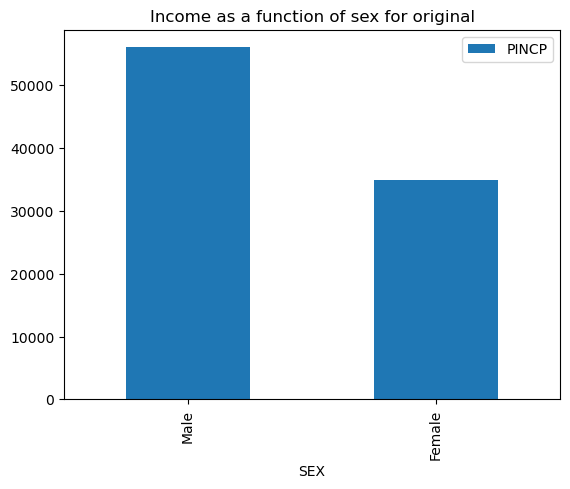

In [34]:
fig, axs = plt.subplots(1,1)
barplotForAvg("Income as a function of sex for original", original, 'SEX', axs, sex_label_mapping)
plt.show()
fig.savefig('income-sex-original.png', bbox_inches='tight')

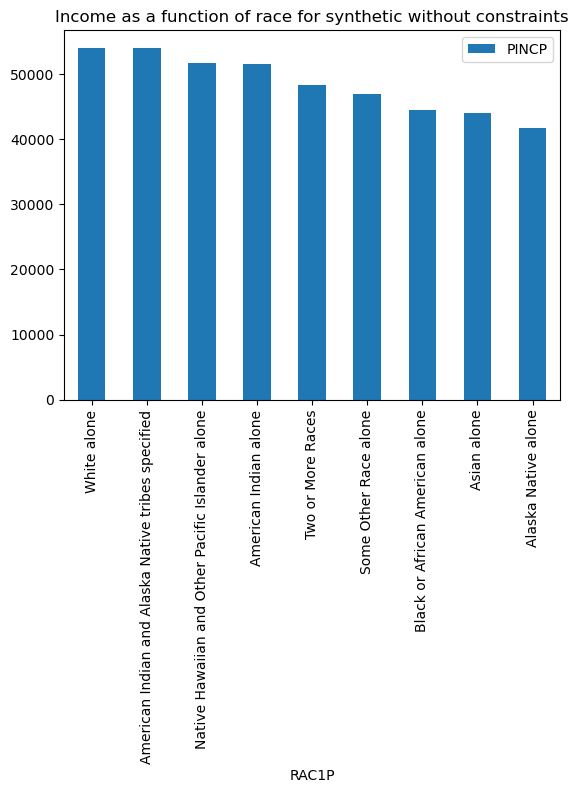

In [35]:
fig, axs = plt.subplots(1,1)
barplotForAvg("Income as a function of race for synthetic without constraints", synthetic_data, 'RAC1P', axs, race_label_mapping)

plt.show()
fig.savefig('income-race-synthetic-without-constraints.png', bbox_inches='tight')

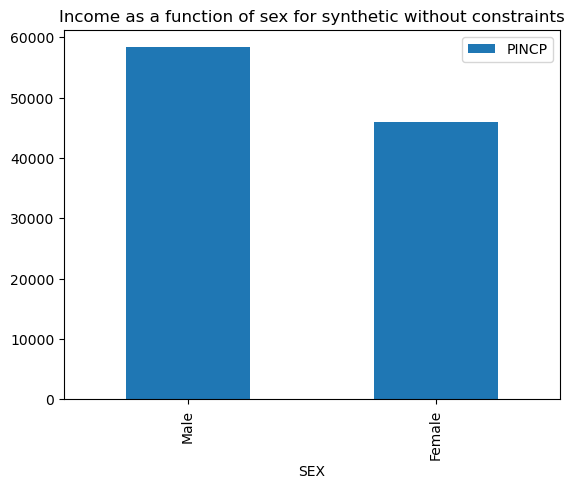

In [36]:
fig, axs = plt.subplots(1,1)
barplotForAvg("Income as a function of sex for synthetic without constraints", synthetic_data, 'SEX', axs, sex_label_mapping)
plt.show()
fig.savefig('income-sex-synthetic-without-constraints.png', bbox_inches='tight')

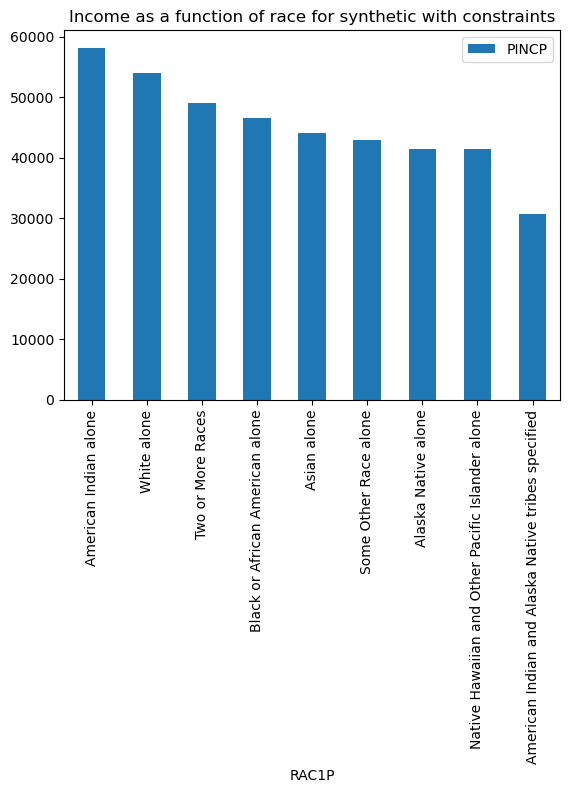

In [37]:
fig, axs = plt.subplots(1,1)
barplotForAvg("Income as a function of race for synthetic with constraints", synthetic_data2, 'RAC1P', axs, race_label_mapping)
plt.show()
fig.savefig('income-race-synthetic-with-constraints.png', bbox_inches='tight')

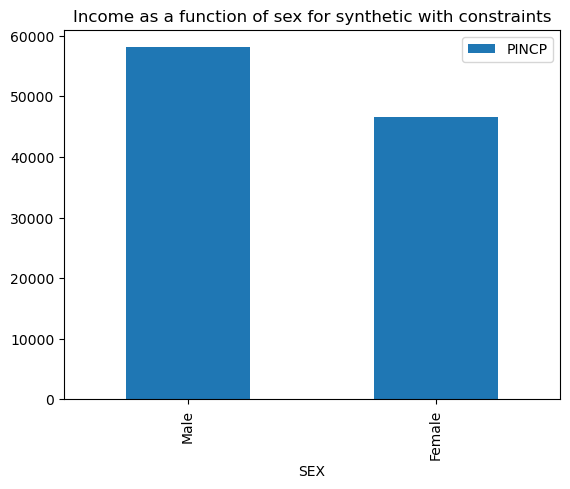

In [38]:
fig, axs = plt.subplots(1,1)
barplotForAvg("Income as a function of sex for synthetic with constraints", synthetic_data2, 'SEX', axs, sex_label_mapping)
plt.show()
fig.savefig('income-sex-synthetic-with-constraints.png', bbox_inches='tight')

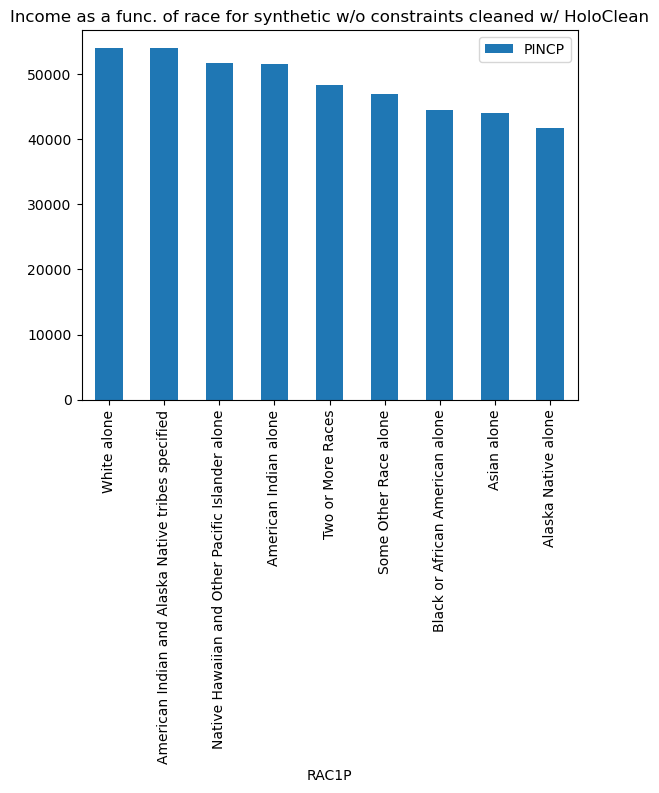

In [39]:
fig, axs = plt.subplots(1,1)
barplotForAvg("Income as a func. of race for synthetic w/o constraints cleaned w/ HoloClean", holoclean_data, 'RAC1P', axs, race_label_mapping)
plt.show()
fig.savefig('income-race-holoclean.png', bbox_inches='tight')

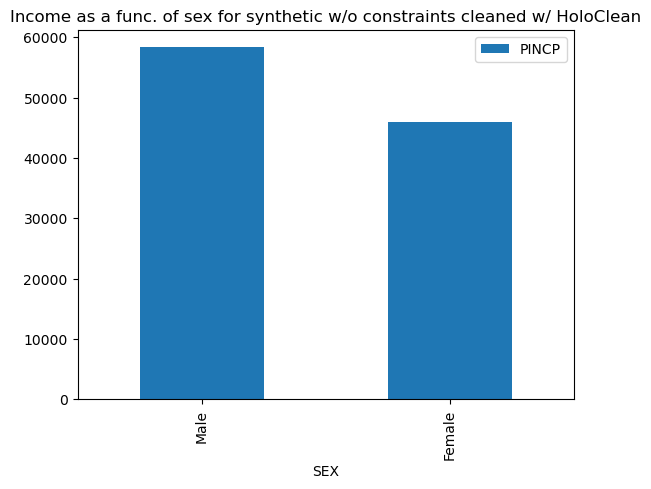

In [40]:
fig, axs = plt.subplots(1,1)
barplotForAvg("Income as a func. of sex for synthetic w/o constraints cleaned w/ HoloClean", holoclean_data, 'SEX', axs, sex_label_mapping)
plt.show()
fig.savefig('income-sex-holoclean.png', bbox_inches='tight')

In [41]:
#The reference to the data, what I did too the data, what FD i used, what is the data generation system I used for synthetic data, how many FD violatoons, distiiultions from the graphs, we need to know the same statistics and number of violations
#Have a section of description of data and data processing
#bib file for references in Overleaf

#Synthetic data generation and blind cleaning --> distributions of interest change, representation of different subpopulation for different subgroups in the data, at least preserve the truthgul original distributions, otherwise, for leaning we are not sending the right thing. Distributon in some view (query answrr) for example income vs gender,race, being truthful to that or not. Distributin change may be ok but ranking is the third type of problem that we want to preserve. 
#Repeat this for disability and age
#Adding the Muse graphs for all of this
#Find out the number of violations before (after synthetic data generation) and after I clean (for Holoclean and Muse), we want to know for example in holoclean, if the num of violation is beyond some percentage in the data, it won't do anything. We khave to know if it gave up and did nothing. probabilisitc not deterministic repair. 

# 1 table for how the numbers are changing for the 6 plots and the graphs below it. column for every graph
# 1 table for race, one for gender, one for disability, report later


import math

merging_data = new_data[['SERIALNO', 'ST', 'REGION']]
num_rows = merging_data.shape[0]
maxViolations = math.comb(num_rows,2)

result = pd.merge(merging_data, merging_data, how='inner', left_on=['ST'], right_on=['ST'], suffixes=('_left', '_right'))
result = result[result['SERIALNO_left'] > result['SERIALNO_right']]
result = result[result['REGION_left'] != result['REGION_right']]
num_violations = result.shape[0]
print(f"{num_violations} pairs of tuples violate the ST -> REGION FD. The maximum possible violations are {maxViolations}. The percentage is {num_violations/maxViolations:.3%}")

NameError: name 'new_data' is not defined

In [ ]:
#Whether the salary distributions constraints

#Given outcome of interest, try with different combination of functional dependencies, run synthtic data generator one at a time , see if the distribution changes of an attibute of interest varying some other parameters (race, age, gender), race, age, gender, insurance vs length of stay

# Given outcome of interest, try with different combination of functional dependencies, run synthtic data generator one at a time , see if the distribution changes of an attibute of interest varying some other parameters (race, age, gender), race, age, gender, insurance vs length of stay
# Repeat those plots for a combination of functional depenecy, whether the outcome of interest changes even if the denial constraints have or do not have nothing to do with the outcome of interest
# Adding constraints preserves the outcome of interest?  Motivate the need for generatting clean data satisfying constrains while preserving the distibutino of an outcome of interest. Seeing if there is an issue with the data generators of interest.

# Seee if the other data generators allow for functional dependency constraints

# data genration and data cleaning algorithms are imperfect when it comes to bias, these systems have limiations, messing up with bias or distributions or both, so we have to fiz something in those systems/problems
#original, synthetic constraints, synthetic data without constraints and then clean the data with holoclean, denian constraints, 
#add database_reset(db) before every time in line 76 of running_example.py